In [1]:
import os
import sys
from glob import glob

import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import shared.utils as su
from utils.video import read_frames_decord

### Load data

In [6]:
data_root = "/scratch/shared/beegfs/piyush/datasets/MSRVTT"
video_dir = f"{data_root}/videos/all/"

data = su.io.load_json(f"{data_root}/annotation/msrvtt_test_1k.json")
df = pd.DataFrame(data)

df['video_path'] = df.video.apply(lambda x: f"{video_dir}/{x}")
df['video_path'].apply(os.path.exists).mean()

text_col = "caption"
df.shape

vid2text = {}
for f in video_embeds:
    vid2text[f] = df[df.video_path == f].iloc[0][text_col]
len(vid2text)

df.iloc[0].to_dict()

{'video_id': 'video7020',
 'video': 'video7020.mp4',
 'caption': 'a woman creating a fondant baby and flower',
 'source': 'MSR-VTT',
 'category': 10,
 'url': 'https://www.youtube.com/watch?v=4KRMJNBjrEs',
 'start time': 221.77,
 'end time': 233.08,
 'id': 7020,
 'video_path': '/scratch/shared/beegfs/piyush/datasets/MSRVTT/videos/all//video7020.mp4'}

15.215650000000002


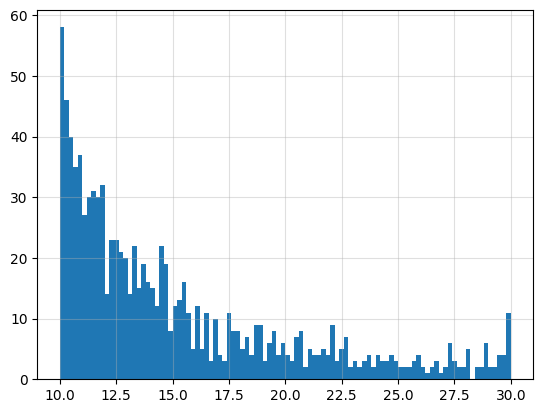

In [6]:
df['duration'] = df['end time'] - df['start time']
print(df['duration'].mean())

plt.hist(df['duration'], bins=100);
plt.grid(alpha=0.4)
plt.show()

### Qwen3VL-Embedding-8B

In [5]:
from models.qwen3vl_embedding import Qwen3VLEmbedder

model_name_or_path = "/work/piyush/pretrained_checkpoints/Qwen3-VL-Embedding-8B/"
model = Qwen3VLEmbedder(
    model_name_or_path=model_name_or_path,
    torch_dtype=torch.float16,
    attn_implementation="flash_attention_2",
    device_map="cuda:0",
)
su.misc.num_params(model.model)

`torch_dtype` is deprecated! Use `dtype` instead!


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

::: Number of total parameters in Qwen3VLForEmbedding: 8144.794M


In [9]:
def gather_text_features(model, texts: list):
    """Compute text embeddings for all unique text IDs."""
    texts_feat = {}
    for j, text in enumerate(
        su.log.tqdm_iterator(texts, desc='Computing text features')
    ):
        emb = model.process([{'text': text}])
        zt = emb.squeeze(0).cpu().float()
        texts_feat[text] = zt
        if j == 0:
            print("Text embedding:", zt.shape)
    return texts_feat


def gather_video_features(model, video_paths: list, num_frames=8):
    """Compute video embeddings for all unique video IDs."""
    video_feat = {}
    for j, video_path in enumerate(
        su.log.tqdm_iterator(video_paths, desc='Computing video features')
    ):
        emb = model.process([{
            'video': video_path,
            # num_frames: samples frames uniformly ignoring FPS
            # If this is passed, max_frames is also ignored
            'num_frames': num_frames,
        }])
        zv = emb.squeeze(0).cpu().float()
        video_feat[video_path] = zv
        if j == 0:
            print("Video embedding:", zv.shape)
    return video_feat

### Qwen 3 VL

In [7]:
from models.qwen3vl import EncoderForQwen3VL

model_path = "/work/piyush/pretrained_checkpoints/Qwen3-VL-8B-Instruct/"
model = EncoderForQwen3VL.from_pretrained(
    model_path, dtype=torch.bfloat16, device_map="auto", attn_implementation="flash_attention_2",
)
su.misc.num_params(model.model)

`torch_dtype` is deprecated! Use `dtype` instead!


Loading EncoderForQwen3VL from /work/piyush/pretrained_checkpoints/Qwen3-VL-8B-Instruct/


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

The module name  (originally ) is not a valid Python identifier. Please rename the original module to avoid import issues.


::: Number of total parameters in Qwen3VLForConditionalGeneration: 8767.124M


In [8]:
model.encode_text('sample').shape

frames = read_frames_decord(video_path='../../TimeBound.v1/sample_data/folding_paper.mp4', num_frames=8)
frames.shape

torch.Size([8, 3, 240, 426])

In [11]:
frames = read_frames_decord(video_path='/scratch/shared/beegfs/piyush/datasets/MSRVTT/videos/all//video7212.mp4', num_frames=8)
frames.shape

torch.Size([8, 3, 240, 320])

In [9]:
def gather_text_features(model, texts: list):
    """Compute text embeddings for all unique text IDs."""
    texts_feat = {}
    for j, text in enumerate(
        su.log.tqdm_iterator(texts, desc='Computing text features')
    ):
        emb = model.encode_text(text)
        zt = emb.squeeze(0).cpu().float()
        texts_feat[text] = zt
        if j == 0:
            print("Text embedding:", zt.shape)
    return texts_feat


def gather_video_features(model, video_paths: list, num_frames=8):
    """Compute video embeddings for all unique video IDs."""
    video_feat = {}
    for j, video_path in enumerate(
        su.log.tqdm_iterator(video_paths, desc='Computing video features')
    ):
        try:
            frames = read_frames_decord(video_path=video_path, num_frames=num_frames)
        except:
            print(f"Failed reading {video_path}. Using dummy inputs.")
            frames = torch.zeros((num_frames, 3, 256, 256), dtype=int)
        emb = model.encode_vision(frames.unsqueeze(0))
        zv = emb.squeeze(0).cpu().float()
        video_feat[video_path] = zv
        if j == 0:
            print("Video embedding:", zv.shape)
    return video_feat

### InternVL3

In [24]:
from models.internvl3 import EncoderForInternVL3

model_path = "/work/piyush/pretrained_checkpoints/InternVL3-8B/"
model = EncoderForInternVL3.from_pretrained(
    model_path, dtype=torch.bfloat16, device_map="auto", attn_implementation="flash_attention_2",
)
su.misc.num_params(model.model)

The module name  (originally ) is not a valid Python identifier. Please rename the original module to avoid import issues.
The module name  (originally ) is not a valid Python identifier. Please rename the original module to avoid import issues.
`torch_dtype` is deprecated! Use `dtype` instead!
The module name  (originally ) is not a valid Python identifier. Please rename the original module to avoid import issues.
The module name  (originally ) is not a valid Python identifier. Please rename the original module to avoid import issues.


Loading EncoderForInternVL3 from /work/piyush/pretrained_checkpoints/InternVL3-8B/


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

The module name  (originally ) is not a valid Python identifier. Please rename the original module to avoid import issues.


::: Number of total parameters in InternVLChatModel: 7944.374M


In [25]:
print(model.encode_text('sample').shape)

frames = read_frames_decord(video_path='../../TimeBound.v1/sample_data/folding_paper.mp4', num_frames=8)
print(model.encode_vision(frames.unsqueeze(0)).shape)

Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


torch.Size([1, 3584])


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


torch.Size([1, 3584])


### Qwen2-VL

In [85]:
from models.modeling_encoders import EncoderForQwen2VL

model_path = "/work/piyush/pretrained_checkpoints/Qwen2-VL-7B-Instruct/"
model = EncoderForQwen2VL.from_pretrained(
    model_path, dtype=torch.bfloat16, device_map="auto", attn_implementation="flash_attention_2",
)
su.misc.num_params(model.model)

Unrecognized keys in `rope_scaling` for 'rope_type'='default': {'mrope_section'}
`Qwen2VLRotaryEmbedding` can now be fully parameterized by passing the model config through the `config` argument. All other arguments will be removed in v4.46


Loading EncoderForQwen2VL from /work/piyush/pretrained_checkpoints/Qwen2-VL-7B-Instruct/


Loading checkpoint shards:   0%|          | 0/5 [00:00<?, ?it/s]

::: Number of total parameters in Qwen2VLForConditionalGeneration: 8291.376M


In [7]:
from models.modeling_encoders import EncoderForCaRe

# model_path = "/work/piyush/pretrained_checkpoints/CaRe-7B"
model_path = "/work/piyush/pretrained_checkpoints/CaRe-7B-Stage-1/"
model = EncoderForCaRe.from_pretrained(
    model_path, dtype=torch.bfloat16, device_map="auto", attn_implementation="flash_attention_2",
)
su.misc.num_params(model.model)

Unrecognized keys in `rope_scaling` for 'rope_type'='default': {'mrope_section'}
`Qwen2VLRotaryEmbedding` can now be fully parameterized by passing the model config through the `config` argument. All other arguments will be removed in v4.46


Loading EncoderForCaRe from /work/piyush/pretrained_checkpoints/CaRe-7B-Stage-1/


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

::: Number of total parameters in Qwen2VLForConditionalGeneration: 8291.376M


In [8]:
print(model.encode_text('sample').shape)

frames = read_frames_decord(video_path='../../TimeBound.v1/sample_data/folding_paper.mp4', num_frames=8)
print(model.encode_vision(frames.unsqueeze(0)).shape)

From v4.47 onwards, when a model cache is to be returned, `generate` will return a `Cache` instance instead by default (as opposed to the legacy tuple of tuples format). If you want to keep returning the legacy format, please set `return_legacy_cache=True`.


torch.Size([1, 3584])
torch.Size([1, 3584])


In [9]:
def gather_text_features(model, texts: list):
    """Compute text embeddings for all unique text IDs."""
    texts_feat = {}
    for j, text in enumerate(
        su.log.tqdm_iterator(texts, desc='Computing text features')
    ):
        emb = model.encode_text(text)
        zt = emb.squeeze(0).cpu().float()
        texts_feat[text] = zt
        if j == 0:
            print("Text embedding:", zt.shape)
    return texts_feat


def gather_video_features(model, video_paths: list, num_frames=8):
    """Compute video embeddings for all unique video IDs."""
    video_feat = {}
    for j, video_path in enumerate(
        su.log.tqdm_iterator(video_paths, desc='Computing video features')
    ):
        try:
            frames = read_frames_decord(video_path=video_path, num_frames=num_frames)
        except:
            print(f"Failed reading {video_path}. Using dummy inputs.")
            frames = torch.zeros((num_frames, 3, 256, 256), dtype=int)
        emb = model.encode_vision(frames.unsqueeze(0))
        zv = emb.squeeze(0).cpu().float()
        video_feat[video_path] = zv
        if j == 0:
            print("Video embedding:", zv.shape)
    return video_feat

### Tarsier2

In [7]:
from models.modeling_encoders import EncoderForTarsier2

model_path = "/work/piyush/pretrained_checkpoints/Tarsier2-7b-0115"
model = EncoderForTarsier2.from_pretrained(
    model_path, dtype=torch.bfloat16, device_map="auto", attn_implementation="flash_attention_2",
)
su.misc.num_params(model.model)

The argument `trust_remote_code` is to be used with Auto classes. It has no effect here and is ignored.
Unrecognized keys in `rope_scaling` for 'rope_type'='default': {'mrope_section'}


Loading EncoderForTarsier2 from /work/piyush/pretrained_checkpoints/Tarsier2-7b-0115


The argument `trust_remote_code` is to be used with Auto classes. It has no effect here and is ignored.
The model weights are not tied. Please use the `tie_weights` method before using the `infer_auto_device` function.


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

::: Number of total parameters in Tarsier2ForConditionalGeneration: 8291.376M


In [14]:
print(model.encode_text('sample').shape)
print(model.encode_vision(video_path='../../TimeBound.v1/sample_data/folding_paper.mp4').shape)

Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


[cuda:0] num_images: [0] num_image_tokens: [0]
torch.Size([1, 3584])


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


[cuda:0] num_images: [32] num_image_tokens: [2160]
torch.Size([1, 3584])


In [56]:
model.encode_text('sample')

Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


[cuda:0] num_images: [0] num_image_tokens: [0]


tensor([[-0.6367,  5.3438,  4.9375,  ...,  1.4688, -1.5625,  0.8945]],
       device='cuda:0', dtype=torch.bfloat16)

In [57]:
model.encode_text('hello')

Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


[cuda:0] num_images: [0] num_image_tokens: [0]


tensor([[-3.3438,  2.2031,  5.1250,  ...,  4.6562, -3.1250, -2.3281]],
       device='cuda:0', dtype=torch.bfloat16)

In [58]:
def gather_text_features(model, texts: list):
    """Compute text embeddings for all unique text IDs."""
    texts_feat = {}
    for j, text in enumerate(
        su.log.tqdm_iterator(texts, desc='Computing text features')
    ):
        emb = model.encode_text(text)
        zt = emb.squeeze(0).cpu().float()
        texts_feat[text] = zt
        if j == 0:
            print("Text embedding:", zt.shape)
    return texts_feat


def gather_video_features(model, video_paths: list, num_frames=8):
    """Compute video embeddings for all unique video IDs."""
    video_feat = {}
    for j, video_path in enumerate(
        su.log.tqdm_iterator(video_paths, desc='Computing video features')
    ):
        emb = model.encode_vision(video_path)
        zv = emb.squeeze(0).cpu().float()
        video_feat[video_path] = zv
        if j == 0:
            print("Video embedding:", zv.shape)
    return video_feat

### Tarsier/TARA

In [45]:
save_dir = "/work/piyush/experiments/CaRe/embeddings"

# key = 'Tarsier (Base Model)'
key = 'TARA (Ours)'
video_embeds = torch.load(f"{save_dir}/video_embeds-tarsier-tara-msrvtt.pt")[key]
texts_embeds = torch.load(f"{save_dir}/texts_embeds-tarsier-tara-msrvtt.pt")[key]

### Compute embeddings

In [10]:
texts_embeds = gather_text_features(model, df[text_col].unique())
len(texts_embeds)

Computing text features:   0%|          | 0/995 [00:00<?, ?it/s]

Text embedding: torch.Size([3584])


995

In [11]:
video_embeds = gather_video_features(model, df.video_path.unique())
len(video_embeds)

Computing video features:   0%|          | 0/1000 [00:00<?, ?it/s]

Video embedding: torch.Size([3584])


It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.


1000

In [13]:
# Save
save_dir = "/work/piyush/experiments/CaRe/embeddings"

# model_key = "internvl3_8b_eol"
# model_key = "qwen2vl7b"
# model_key = "care"
# model_key = "tarsier7b"
# model_key = "tara"
# model_key = "tarsier2"
# model_key = "qwen3vl8b"
model_key = "care_stage1"

# torch.save(video_embeds, f"{save_dir}/video_embeds-qwne3vlembedding8b-msrvtt.pt")
# torch.save(texts_embeds, f"{save_dir}/texts_embeds-qwne3vlembedding8b-msrvtt.pt")

# torch.save(video_embeds, f"{save_dir}/video_embeds-qwne3vl_eol-msrvtt.pt")
# torch.save(texts_embeds, f"{save_dir}/texts_embeds-qwne3vl_eol-msrvtt.pt")

torch.save(video_embeds, f"{save_dir}/video_embeds-{model_key}-msrvtt.pt")
torch.save(texts_embeds, f"{save_dir}/texts_embeds-{model_key}-msrvtt.pt")

In [14]:
vid2text = {}
for f in video_embeds:
    vid2text[f] = df[df.video_path == f].iloc[0][text_col]
len(vid2text)

1000

In [15]:
X = []
Y = [] 
for i in range(len(df)):
    row = df.iloc[i].to_dict()
    zv = video_embeds[row['video_path']]
    zt = texts_embeds[row[text_col]]
    X.append(zv)
    Y.append(zt)
norm = lambda x: torch.nn.functional.normalize(x, dim=-1)
X = norm(torch.stack(X))
Y = norm(torch.stack(Y))
delta = np.round((X.mean(dim=0) - Y.mean(dim=0)).norm(dim=-1).item(), 2)
delta

0.4

In [13]:
def visualize_modality_gap(_video_embeds: dict, _texts_embeds: dict, vid2text: dict, method='tsne', save_path=None, title='Modality Gap'):
    norm = lambda x: torch.nn.functional.normalize(x, dim=-1)
    ZV = torch.stack([_video_embeds[f] for f in _video_embeds])
    ZT = torch.stack([_texts_embeds[t] for t in _texts_embeds])
    Z = torch.concatenate([ZV, ZT], dim=0)
    Z = norm(Z)
    z = su.visualize.reduce_dim(Z, method=method)

    delta = np.round((norm(ZV).mean(dim=0) - norm(ZT).mean(dim=0)).norm(dim=-1).item(), 3)

    # Create mappings from video/text to their index in z
    video_list = list(_video_embeds.keys())
    text_list = list(_texts_embeds.keys())
    
    fig, ax = plt.subplots(1, 1, figsize=(6, 5))
    
    # Draw matching lines first (so they appear behind the points)
    for i, f in enumerate(video_list):
        matched_text = vid2text[f]
        if matched_text in text_list:
            j = text_list.index(matched_text)
            # Draw line from video point to text point
            ax.plot([z[i, 0], z[len(ZV) + j, 0]], 
                    [z[i, 1], z[len(ZV) + j, 1]], 
                    color='lightgray', linewidth=0.5, alpha=0.5, zorder=1)
    
    # Draw scatter points on top
    ax.scatter(z[:len(ZV), 0], z[:len(ZV), 1], s=8, label='Video', zorder=2)
    ax.scatter(z[len(ZV):, 0], z[len(ZV):, 1], s=8, label='Text', zorder=2)
    
    ax.grid(alpha=0.3)
    ax.set_xlabel("$\\mathbf{z}_{1}$")
    ax.set_ylabel("$\\mathbf{z}_{2}$")
    ax.legend(fontsize=12)
    
    title += " ($|| \\vec{\Delta}_{\\text{gap}}|| = %s $)" % delta
    ax.set_title(title, fontsize=14)

    if save_path is not None:
        plt.savefig(save_path, bbox_inches='tight')
    plt.show()

In [48]:
# save_path = '../figures/qwen3vlembedding8b-msrvtt-modgap.pdf'
save_path = f'../figures/{model_key}-msrvtt-modgap.pdf'
visualize_modality_gap(video_embeds, texts_embeds, vid2text, title=model_key, method='tsne', save_path=save_path)

**Compute measures**

In [17]:
# G = []
X = []
Y = [] 
for i in range(len(df)):
    row = df.iloc[i].to_dict()
    zv = video_embeds[row['video_path']]
    zt = texts_embeds[row[text_col]]
    # g = zv - zt
    # G.append(g)
    X.append(zv)
    Y.append(zt)

# G = torch.stack(G)
norm = lambda x: torch.nn.functional.normalize(x, dim=-1)
X = norm(torch.stack(X))
Y = norm(torch.stack(Y))
G = X - Y
g_mean = torch.mean(G, dim=0)

In [65]:
from shared.utils.embedding_distances import embedding_distance, print_comparison

metrics = embedding_distance(X, Y)

print_comparison(metrics, metrics, "Qwen3VL-Embedding-8B", "NA")

  Metric                         Qwen3VL-Embedding-8B                    NA
--------------------------------------------------------------------------
  centroid_cosine_similarity                 0.828464              0.828464
  centroid_euclidean_distance                0.492054              0.492054
  emd_euclidean                              0.787227              0.787227
  emd_cosine                                 0.312275              0.312275
  mmd_rbf                                    0.069505              0.069505
  kl_xy                                    846.549506            846.549506
  kl_yx                                    677.747204            677.747204
  js_divergence                            762.148355            762.148355
  frechet_distance                           0.370141              0.370141
  silhouette_euclidean                       0.157488              0.157488
  silhouette_cosine                          0.285147              0.285147
  calinski_ha

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

def plot_hist_with_distribution(ax, values, nbins=100):
    """
    Plot histogram with smooth KDE curve and mean line.

    Parameters
    ----------
    ax : matplotlib.axes.Axes
        Axis to plot on.
    values : array-like
        1D numeric data.
    nbins : int, optional
        Number of histogram bins (default=100).
    """
    values = np.asarray(values)
    values = values[np.isfinite(values)]  # remove NaNs/Infs

    # Histogram (density normalized)
    ax.hist(values, bins=nbins, density=True, alpha=0.5, label="Histogram")

    # KDE curve
    kde = gaussian_kde(values)
    x = np.linspace(values.min(), values.max(), 1000)
    ax.plot(x, kde(x), linewidth=2, label="KDE")

    # Mean line
    mean_val = values.mean()
    ax.axvline(mean_val, linestyle="--", linewidth=2,
               label=f"Mean = {mean_val:.3f}")

    ax.legend()
    ax.set_ylabel("Density")
    ax.set_xlabel("Value")

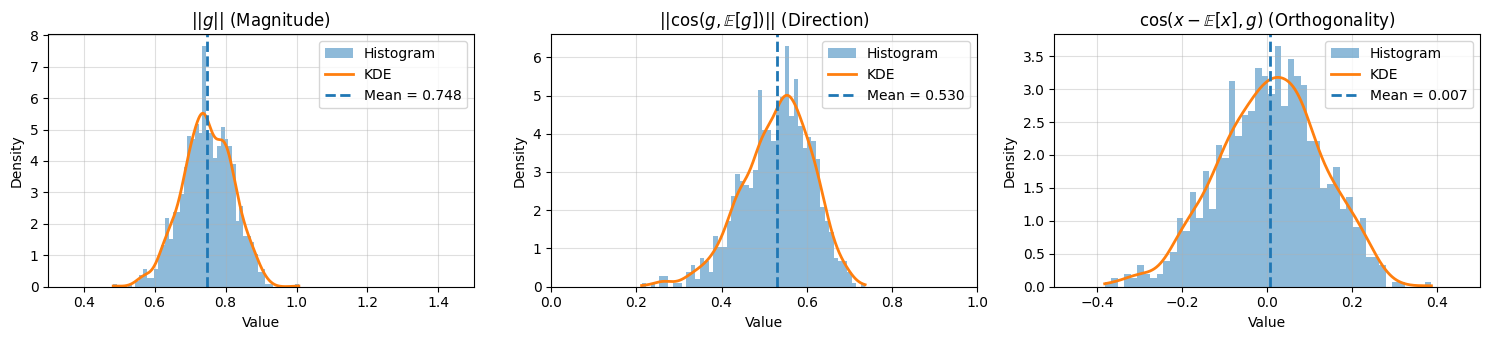

In [19]:
axwidth = 5
axheight = 3.5
ncols = 3
nrows = 1

fig, axes = plt.subplots(nrows, ncols, figsize=(ncols * axwidth, nrows * axheight))

ax = axes[0]
ax.grid(alpha=0.4)
plot_hist_with_distribution(ax, G.norm(dim=-1), nbins=50)
ax.set_xlim(0.3, 1.5)
ax.set_title("$ || g || $ (Magnitude)")


ax = axes[1]
ax.grid(alpha=0.4)
vals = torch.cosine_similarity(G, G.mean(dim=0, keepdims=True))
plot_hist_with_distribution(ax, vals, nbins=50)
ax.set_title("$ || \cos(g, \mathbb{E}[g]) || $ (Direction)")
ax.set_xlim(0, 1)

ax = axes[2]
ax.grid(alpha=0.4)
vals = torch.cosine_similarity(X - X.mean(dim=0, keepdims=True), G.mean(dim=0, keepdims=True))
plot_hist_with_distribution(ax, vals, nbins=50)
ax.set_xlim(-0.5, 0.5)
ax.set_title("$\cos(x - \mathbb{E}[x], g)$ (Orthogonality)")

plt.tight_layout()
# save_path='../figures/qwen3vlembedding8b-msrvtt-stats.pdf'
save_path = f'../figures/{model_key}-msrvtt-stats.pdf'
plt.savefig(save_path, bbox_inches="tight")
plt.show()

In [20]:
import numpy as np

def highest_density_interval(values, mass=0.95):
    """
    Compute the highest-density interval (HDI) for a 1D array of samples.
    
    Parameters:
        values (array-like): Sample values
        mass (float): Fraction of total mass to include (default 0.95)
        
    Returns:
        (lower, upper): Bounds of the HDI
    """
    values = np.sort(np.asarray(values))
    n = len(values)
    
    if n == 0:
        raise ValueError("Input array is empty.")
    if not 0 < mass < 1:
        raise ValueError("mass must be between 0 and 1.")
    
    interval_size = int(np.floor(mass * n))
    if interval_size < 1:
        raise ValueError("Not enough data points for requested mass.")

    # Widths of all candidate intervals
    widths = values[interval_size:] - values[:n - interval_size]
    
    min_idx = np.argmin(widths)
    
    hdi_lower = values[min_idx]
    hdi_upper = values[min_idx + interval_size]
    
    return hdi_lower, hdi_upper


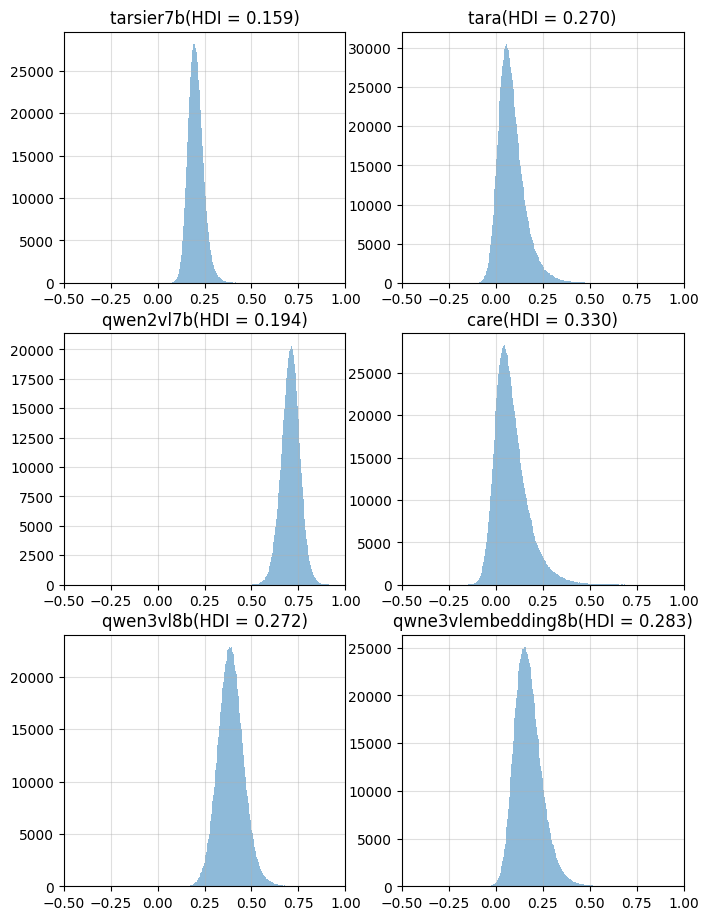

In [38]:
save_dir = "/work/piyush/experiments/CaRe/embeddings"

model_keys = ['tarsier7b', 'tara', 'qwen2vl7b', 'care', 'qwen3vl8b', 'qwne3vlembedding8b']

nrows = len(model_keys) // 2
ncols = 2

fig, axes = plt.subplots(nrows, ncols, figsize=(4 * ncols, 3.7 * nrows))
j = 0
for model_key in model_keys:
    video_embeds = torch.load(f"{save_dir}/video_embeds-{model_key}-msrvtt.pt")
    texts_embeds = torch.load(f"{save_dir}/texts_embeds-{model_key}-msrvtt.pt")
    
    norm = lambda x: torch.nn.functional.normalize(x, dim=-1)
    X = []
    Y = [] 
    for i in range(len(df)):
        row = df.iloc[i].to_dict()
        zv = video_embeds[row['video_path']]
        zt = texts_embeds[row[text_col]]
        X.append(zv)
        Y.append(zt)
    X = norm(torch.stack(X))
    Y = norm(torch.stack(Y))
    
    sims = (X @ Y.T).flatten()
    # sims = torch.arccos(sims)
    l, h = highest_density_interval(sims)
    d = h - l

    ax = axes[j // 2][j % 2]
    # fig, ax = plt.subplots(1, 1, figsize=(6, 4))
    # plot_hist_with_distribution(ax, sims, nbins=200)
    # ax.set_xlim(-0.5, 0.8)
    ax.set_xlim(-0.5, 1)
    ax.hist(sims, bins=200, alpha=0.5)
    ax.grid(alpha=0.4)
    ax.set_title(model_key + f'(HDI = {np.round(d, 3):.3f})')
    j += 1

plt.show()

### Effective dimension

In [18]:
save_dir = "/work/piyush/experiments/CaRe/embeddings"
glob(save_dir + "/video_embeds-*")

['/work/piyush/experiments/CaRe/embeddings/video_embeds-tara-msrvtt.pt',
 '/work/piyush/experiments/CaRe/embeddings/video_embeds-tarsier2-msrvtt.pt',
 '/work/piyush/experiments/CaRe/embeddings/video_embeds-tarsier7b-msrvtt.pt',
 '/work/piyush/experiments/CaRe/embeddings/video_embeds-qwen3vl8b-msrvtt.pt',
 '/work/piyush/experiments/CaRe/embeddings/video_embeds-qwne3vlembedding8b-msrvtt.pt',
 '/work/piyush/experiments/CaRe/embeddings/video_embeds-care-msrvtt.pt',
 '/work/piyush/experiments/CaRe/embeddings/video_embeds-care_stage1-msrvtt.pt',
 '/work/piyush/experiments/CaRe/embeddings/video_embeds-qwen2vl7b-msrvtt.pt']

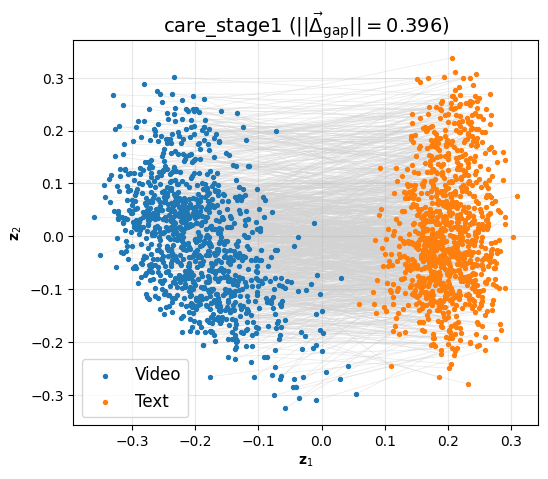

In [19]:
model_key = 'care_stage1'
video_embeds = torch.load(f"{save_dir}/video_embeds-{model_key}-msrvtt.pt")
texts_embeds = torch.load(f"{save_dir}/texts_embeds-{model_key}-msrvtt.pt")
visualize_modality_gap(video_embeds, texts_embeds, vid2text, title=model_key, method='pca', save_path=None)

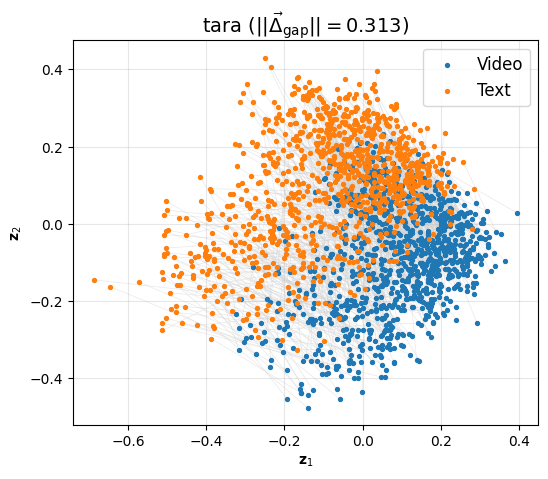

In [8]:
save_dir = "/work/piyush/experiments/CaRe/embeddings"

model_key = 'tarsier7b'
video_embeds = torch.load(f"{save_dir}/video_embeds-{model_key}-msrvtt.pt")
texts_embeds = torch.load(f"{save_dir}/texts_embeds-{model_key}-msrvtt.pt")
visualize_modality_gap(video_embeds, texts_embeds, vid2text, title=model_key, method='pca', save_path=None)

In [34]:
def compute_eff_dim(X, gamma=0.95): # X: N x D

    # Compute covariance matrix: D x D
    C = torch.cov(X.T)
    
    # Run SVD on C to get the singular values
    U, S, V = torch.linalg.svd(C)
    A = np.cumsum(S) / S.sum()
    
    d_eff = np.argmax(A > gamma).item()

    return d_eff, S


X.shape, Y.shape

(torch.Size([1000, 3584]), torch.Size([1000, 3584]))

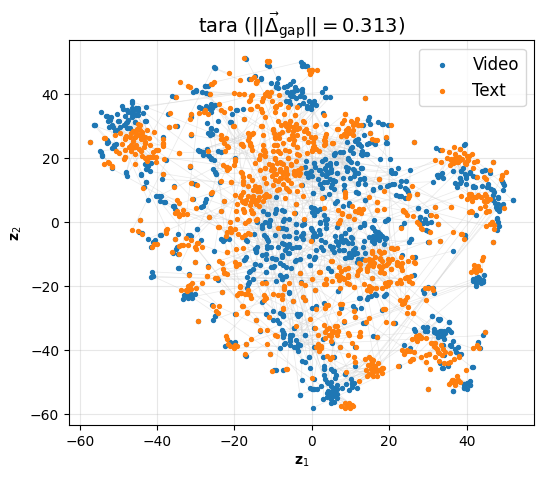

In [ ]:
X = []
Y = [] 
for i in range(len(df)):
    row = df.iloc[i].to_dict()
    zv = video_embeds[row['video_path']]
    zt = texts_embeds[row[text_col]]
    X.append(zv)
    Y.append(zt)
norm = lambda x: torch.nn.functional.normalize(x, dim=-1)
# norm = lambda x: x
X = norm(torch.stack(X))
Y = norm(torch.stack(Y))
(X.mean(dim=0) - Y.mean(dim=0)).norm(dim=-1)

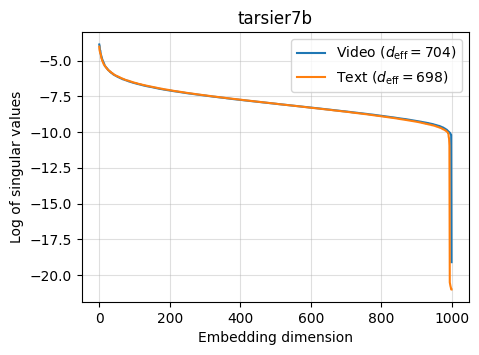

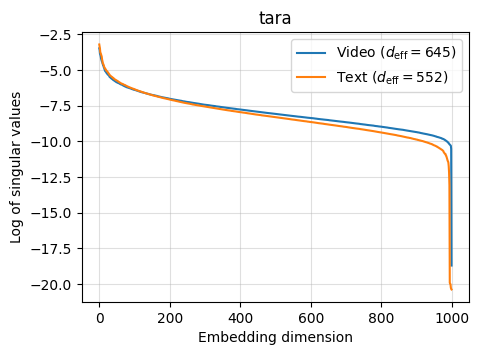

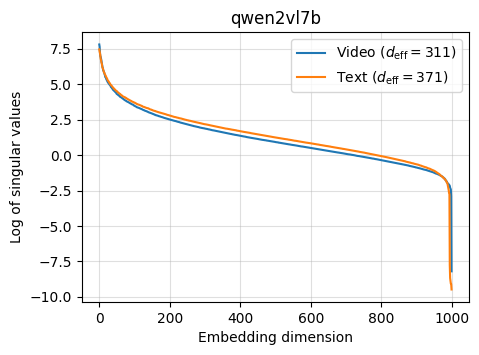

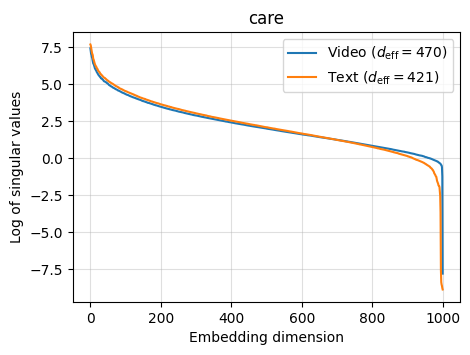

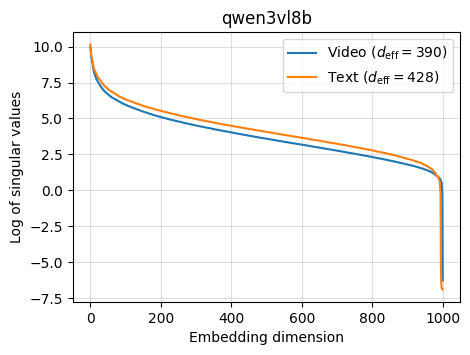

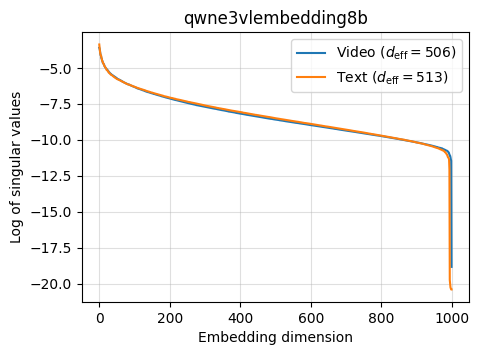

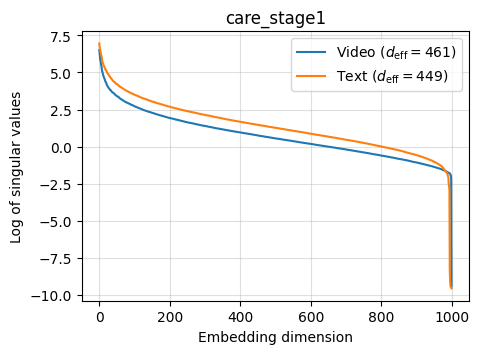

In [43]:
save_dir = "/work/piyush/experiments/CaRe/embeddings"

model_keys = ['tarsier7b', 'tara', 'qwen2vl7b', 'care', 'qwen3vl8b', 'qwne3vlembedding8b', 'care_stage1']

for model_key in model_keys:
    video_embeds = torch.load(f"{save_dir}/video_embeds-{model_key}-msrvtt.pt")
    texts_embeds = torch.load(f"{save_dir}/texts_embeds-{model_key}-msrvtt.pt")

    X = []
    Y = [] 
    for i in range(len(df)):
        row = df.iloc[i].to_dict()
        zv = video_embeds[row['video_path']]
        zt = texts_embeds[row[text_col]]
        X.append(zv)
        Y.append(zt)
    norm = lambda x: torch.nn.functional.normalize(x, dim=-1)
    # norm = lambda x: x
    X = norm(torch.stack(X))
    Y = norm(torch.stack(Y))

    d_eff_x, s_x = compute_eff_dim(X)
    d_eff_y, s_y = compute_eff_dim(Y)
    # s_x = s_x[:1000]
    # s_y = s_y[:1000]
    d = len(s_x)

    fig, ax = plt.subplots(1, 1, figsize=(5, 3.5))
    ax.plot(np.arange(d), torch.log(s_x), label='Video ($d_{\\text{eff}} = %s $)' % d_eff_x)
    ax.plot(np.arange(d), torch.log(s_y), label='Text ($d_{\\text{eff}} = %s $)' % d_eff_y)
    ax.grid(alpha=0.4)
    ax.set_xlabel("Embedding dimension")
    ax.set_ylabel("Log of singular values")
    ax.set_title(model_key)
    ax.legend()
    plt.show()